Code from https://github.com/dome272/VQGAN-pytorch with changes in parameters to adapt to out FFHQ dataset and for 128 images and also addition of some funcitons such as interpolations, and my own dataloader as well as some structural changes

### Helper functions 

In [43]:
import numpy as np
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
import torchvision

# helper functions
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def normalise(x):
    return (x-x.min())/(x.max()-x.min())


data_dir = './dataset' 

dataset = torchvision.datasets.ImageFolder(root=data_dir,
                           transform=torchvision.transforms.Compose([
                            #    torchvision.transforms.Resize((28,28)),
                               torchvision.transforms.CenterCrop((128,128)),
                               torchvision.transforms.ToTensor(),
                               # torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# --------------------------------------------- #
#                  Module Utils
#            for Encoder, Decoder etc.
# --------------------------------------------- #

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


def plot_images(images):
    x = images["input"]
    reconstruction = images["rec"]
    half_sample = images["half_sample"]
    full_sample = images["full_sample"]

    fig, axarr = plt.subplots(1, 4)
    axarr[0].imshow(x.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[1].imshow(reconstruction.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[2].imshow(half_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[3].imshow(full_sample.cpu().detach().numpy()[0].transpose(1, 2, 0))
    plt.show()


def plot_interpolationss(images):
    out = torch.cat(list(images.values()),3)
    fig, axarr = plt.subplots(8, 1)
    axarr[0].imshow(out.cpu().detach().numpy()[0].transpose(1, 2, 0))
    axarr[1].imshow(out.cpu().detach().numpy()[1].transpose(1, 2, 0))
    axarr[2].imshow(out.cpu().detach().numpy()[2].transpose(1, 2, 0))
    axarr[3].imshow(out.cpu().detach().numpy()[3].transpose(1, 2, 0))
    axarr[4].imshow(out.cpu().detach().numpy()[4].transpose(1, 2, 0))
    axarr[5].imshow(out.cpu().detach().numpy()[5].transpose(1, 2, 0))
    axarr[6].imshow(out.cpu().detach().numpy()[6].transpose(1, 2, 0))
    axarr[7].imshow(out.cpu().detach().numpy()[7].transpose(1, 2, 0))
    plt.show()
    pass

### This consists of architectures for encoder and decoder such as residual bloacks and Group norms etc

#### Group Normalisation and Swish Activation function

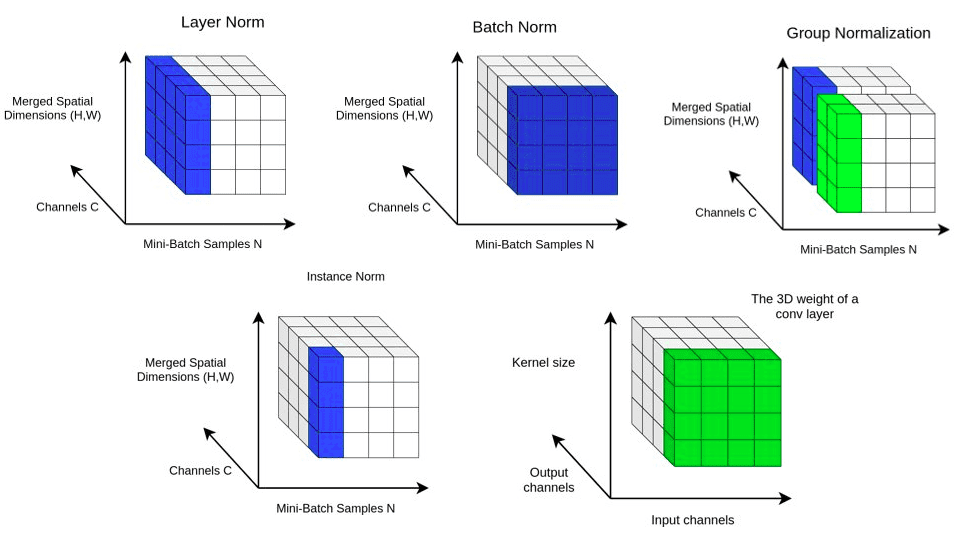

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GroupNorm(nn.Module):
    def __init__(self, channels):
        super(GroupNorm, self).__init__()
        self.gn = nn.GroupNorm(num_groups=32, num_channels=channels, eps=1e-6, affine=True)

    def forward(self, x):
        return self.gn(x)


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

#### Residual Block

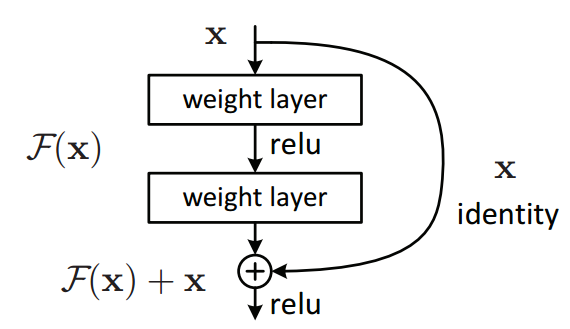

In [45]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.block = nn.Sequential(
            GroupNorm(in_channels),
            Swish(),
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            GroupNorm(out_channels),
            Swish(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        )

        if in_channels != out_channels:
            self.channel_up = nn.Conv2d(in_channels, out_channels, 1, 1, 0)

    def forward(self, x):
        if self.in_channels != self.out_channels:
            return self.channel_up(x) + self.block(x)
        else:
            return x + self.block(x)


#### Upsample and Downsample blocks
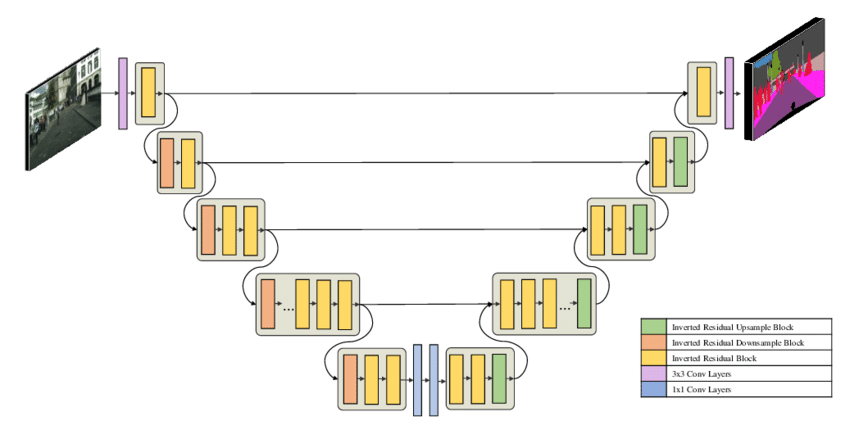

In [46]:
class UpSampleBlock(nn.Module):
    def __init__(self, channels):
        super(UpSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 1, 1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2.0)
        return self.conv(x)


class DownSampleBlock(nn.Module):
    def __init__(self, channels):
        super(DownSampleBlock, self).__init__()
        self.conv = nn.Conv2d(channels, channels, 3, 2, 0)

    def forward(self, x):
        pad = (0, 1, 0, 1)
        x = F.pad(x, pad, mode="constant", value=0)
        return self.conv(x)


class NonLocalBlock(nn.Module):
    def __init__(self, channels):
        super(NonLocalBlock, self).__init__()
        self.in_channels = channels

        self.gn = GroupNorm(channels)
        self.q = nn.Conv2d(channels, channels, 1, 1, 0)
        self.k = nn.Conv2d(channels, channels, 1, 1, 0)
        self.v = nn.Conv2d(channels, channels, 1, 1, 0)
        self.proj_out = nn.Conv2d(channels, channels, 1, 1, 0)

    def forward(self, x):
        h_ = self.gn(x)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        b, c, h, w = q.shape

        q = q.reshape(b, c, h*w)
        q = q.permute(0, 2, 1)
        k = k.reshape(b, c, h*w)
        v = v.reshape(b, c, h*w)

        attn = torch.bmm(q, k)
        attn = attn * (int(c)**(-0.5))
        attn = F.softmax(attn, dim=2)
        attn = attn.permute(0, 2, 1)

        A = torch.bmm(v, attn)
        A = A.reshape(b, c, h, w)

        return x + A

### VQ - VAE
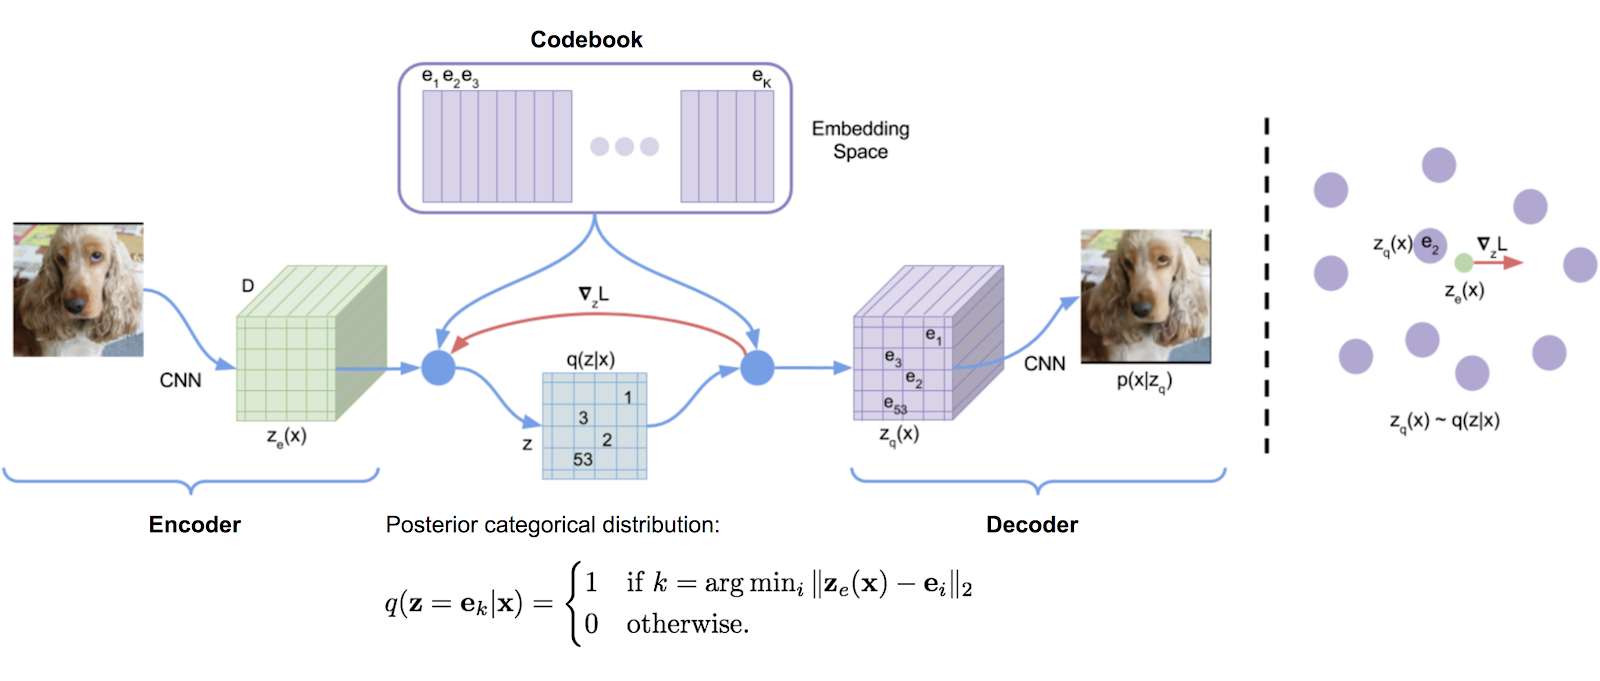

#### Encoder 
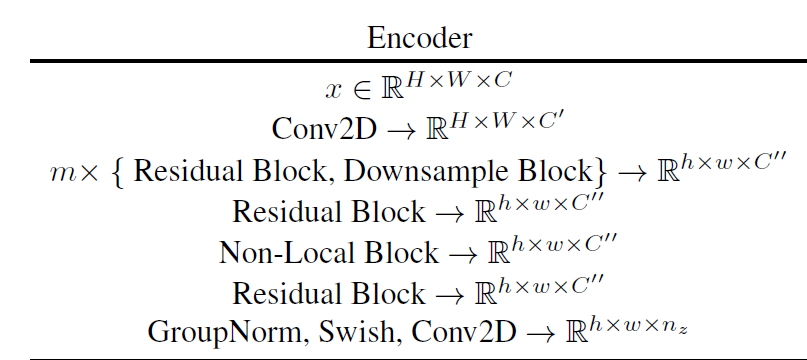

In [47]:
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()
        channels = [64, 64, 64, 128, 128, 256]
        attn_resolutions = [8]
        num_res_blocks = 2
        resolution = 64
        layers = [nn.Conv2d(args['image-channels'], channels[0], 3, 1, 1)]
        for i in range(len(channels)-1):
            in_channels = channels[i]
            out_channels = channels[i + 1]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != len(channels)-2:
                layers.append(DownSampleBlock(channels[i+1]))
                resolution //= 2
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(NonLocalBlock(channels[-1]))
        layers.append(ResidualBlock(channels[-1], channels[-1]))
        layers.append(GroupNorm(channels[-1]))
        layers.append(Swish())
        layers.append(nn.Conv2d(channels[-1], args['latent-dim'], 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

#### Decoder
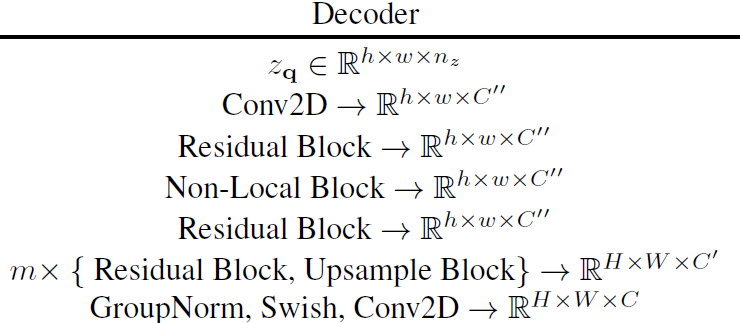

In [48]:
class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()
        channels = [256, 128, 128, 64, 64]
        attn_resolutions = [8]
        num_res_blocks = 3
        resolution = 8

        in_channels = channels[0]
        layers = [nn.Conv2d(args['latent-dim'], in_channels, 3, 1, 1),
                  ResidualBlock(in_channels, in_channels),
                  NonLocalBlock(in_channels),
                  ResidualBlock(in_channels, in_channels)]

        for i in range(len(channels)):
            out_channels = channels[i]
            for j in range(num_res_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
                if resolution in attn_resolutions:
                    layers.append(NonLocalBlock(in_channels))
            if i != 0:
                layers.append(UpSampleBlock(in_channels))
                resolution *= 2

        layers.append(GroupNorm(in_channels))
        layers.append(Swish())
        layers.append(nn.Conv2d(in_channels, args['image-channels'], 3, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

#### Codebook

In [49]:
class Codebook(nn.Module):
    def __init__(self, args):
        super(Codebook, self).__init__()
        self.num_codebook_vectors = args['num-codebook-vectors']
        self.latent_dim = args['latent-dim']
        self.beta = args['beta']

        self.embedding = nn.Embedding(self.num_codebook_vectors, self.latent_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.num_codebook_vectors, 1.0 / self.num_codebook_vectors)

    def forward(self, z):
        z = z.permute(0, 2, 3, 1).contiguous()
        z_flattened = z.view(-1, self.latent_dim)

        d = torch.sum(z_flattened**2, dim=1, keepdim=True) + \
            torch.sum(self.embedding.weight**2, dim=1) - \
            2*(torch.matmul(z_flattened, self.embedding.weight.t()))

        min_encoding_indices = torch.argmin(d, dim=1)
        z_q = self.embedding(min_encoding_indices).view(z.shape)

        loss = torch.mean((z_q.detach() - z)**2) + self.beta * torch.mean((z_q - z.detach())**2)

        z_q = z + (z_q - z).detach()

        z_q = z_q.permute(0, 3, 1, 2)

        return z_q, min_encoding_indices, loss

### VQVAE architecture with all the components

In [50]:
class VQGAN(nn.Module):
    def __init__(self, args):
        super(VQGAN, self).__init__()
        self.encoder = Encoder(args).to(device=args['device'])
        self.decoder = Decoder(args).to(device=args['device'])
        self.codebook = Codebook(args).to(device=args['device'])
        self.quant_conv = nn.Conv2d(args['latent-dim'], args['latent-dim'], 1).to(device=args['device'])
        self.post_quant_conv = nn.Conv2d(args['latent-dim'], args['latent-dim'], 1).to(device=args['device'])

    def forward(self, imgs):
        encoded_images = self.encoder(imgs)
        quant_conv_encoded_images = self.quant_conv(encoded_images)
        codebook_mapping, codebook_indices, q_loss = self.codebook(quant_conv_encoded_images)
        post_quant_conv_mapping = self.post_quant_conv(codebook_mapping)
        decoded_images = self.decoder(post_quant_conv_mapping)

        return decoded_images, codebook_indices, q_loss

    def encode(self, imgs):
        encoded_images = self.encoder(imgs)
        quant_conv_encoded_images = self.quant_conv(encoded_images)
        codebook_mapping, codebook_indices, q_loss = self.codebook(quant_conv_encoded_images)
        return codebook_mapping, codebook_indices, q_loss

    def decode(self, z):
        post_quant_conv_mapping = self.post_quant_conv(z)
        decoded_images = self.decoder(post_quant_conv_mapping)
        return decoded_images

    def calculate_lambda(self, perceptual_loss, gan_loss):
        last_layer = self.decoder.model[-1]
        last_layer_weight = last_layer.weight
        perceptual_loss_grads = torch.autograd.grad(perceptual_loss, last_layer_weight, retain_graph=True)[0]
        gan_loss_grads = torch.autograd.grad(gan_loss, last_layer_weight, retain_graph=True)[0]

        λ = torch.norm(perceptual_loss_grads) / (torch.norm(gan_loss_grads) + 1e-4)
        λ = torch.clamp(λ, 0, 1e4).detach()
        return 0.8 * λ

    @staticmethod
    def adopt_weight(disc_factor, i, threshold, value=0.):
        if i < threshold:
            disc_factor = value
        return disc_factor

    def load_checkpoint(self, path):
        self.load_state_dict(torch.load(path))

### Discriminator (Not used)

In [51]:
"""
PatchGAN Discriminator (https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py#L538)
"""

import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, args, num_filters_last=64, n_layers=3):
        super(Discriminator, self).__init__()

        layers = [nn.Conv2d(args['image-channels'], num_filters_last, 4, 2, 1), nn.LeakyReLU(0.2)]
        num_filters_mult = 1

        for i in range(1, n_layers + 1):
            num_filters_mult_last = num_filters_mult
            num_filters_mult = min(2 ** i, 8)
            layers += [
                nn.Conv2d(num_filters_last * num_filters_mult_last, num_filters_last * num_filters_mult, 4,
                          2 if i < n_layers else 1, 1, bias=False),
                nn.BatchNorm2d(num_filters_last * num_filters_mult),
                nn.LeakyReLU(0.2, True)
            ]

        layers.append(nn.Conv2d(num_filters_last * num_filters_mult, 1, 4, 1, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### Training the VQVAE (VQGAN without the GAN)

In [ ]:
import os
import argparse
from tqdm import tqdm
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import utils as vutils
from lpips import LPIPS

train_loader = torch.utils.data.DataLoader(dataset, batch_size=16,
                                         shuffle=True, num_workers=2)
# # train_iterator = iter(cycle(train_loader))


class TrainVQGAN:
    def __init__(self, args):
        self.vqgan = VQGAN(args).to(device=args['device'])
        if int(args['resume_training']) > 0:
            self.vqgan.load_state_dict(torch.load(f"Model_dictionaries/vqgan_epoch_{args['resume_training']}.pt"))
        self.discriminator = Discriminator(args).to(device=args['device'])
        self.discriminator.apply(weights_init)
        # self.perceptual_loss = LPIPS().eval().to(device=args['device'])
        self.perceptual_loss = LPIPS(net='vgg').eval().to(args['device'])
        self.opt_vq, self.opt_disc = self.configure_optimizers(args)

        self.prepare_training()

        self.train(args)

    def configure_optimizers(self, args):
        lr = args['learning-rate']
        opt_vq = torch.optim.Adam(
            list(self.vqgan.encoder.parameters()) +
            list(self.vqgan.decoder.parameters()) +
            list(self.vqgan.codebook.parameters()) +
            list(self.vqgan.quant_conv.parameters()) +
            list(self.vqgan.post_quant_conv.parameters()),
            lr=lr, eps=1e-08, betas=(args['beta1'], args['beta2'])
        )
        opt_disc = torch.optim.Adam(self.discriminator.parameters(),
                                    lr=lr, eps=1e-08, betas=(args['beta1'], args['beta2']))

        return opt_vq, opt_disc

    @staticmethod
    def prepare_training():
        os.makedirs("Images", exist_ok=True)
        os.makedirs("Model_dictionaries", exist_ok=True)

    def train(self, args):
        train_dataset = train_loader
        steps_per_epoch = len(train_dataset)
        # print(steps_per_epoch)
        for epoch in range(args['resume_training']+1, args['epochs']):
            with tqdm(range(len(train_dataset))) as pbar:
                for i, imgs in zip(pbar, train_dataset):
                    imgs, _ = imgs
                    imgs = imgs.to(args['device'])
                    decoded_images, _, q_loss = self.vqgan(imgs)
                    perceptual_loss = self.perceptual_loss(imgs, decoded_images)
                    rec_loss = torch.abs(imgs - decoded_images)
                    perceptual_rec_loss = args['perceptual-loss-factor'] * perceptual_loss + args['rec-loss-factor'] * rec_loss
                    perceptual_rec_loss = perceptual_rec_loss.mean()
                    vq_loss = perceptual_rec_loss + q_loss
                    self.opt_vq.zero_grad()
                    vq_loss.backward(retain_graph=True)

                    self.opt_vq.step()
                    self.opt_disc.step()



                    pbar.set_postfix(
                        VQ_Loss=np.round(vq_loss.cpu().detach().numpy().item(), 5),
                    )
                    pbar.update(0)
                if epoch % 15 == 0:
                    torch.save(self.vqgan.state_dict(), os.path.join("Model_dictionaries", f"vqgan_epoch_{epoch}.pt"))
                    with torch.no_grad():
                        real_fake_images = torch.cat((imgs[:4], decoded_images[:4]))
                        vutils.save_image(real_fake_images, os.path.join("Images", f"{epoch}_{i}.jpg"), nrow=4)

arguments = dict()
arguments['latent-dim'] = 256
arguments['image-size'] = 128
arguments['num-codebook-vectors'] = 1024
arguments['beta'] = 0.25
arguments['image-channels'] = 3
arguments['device'] = 'cuda'
arguments['batch-size'] = 16
arguments['epochs'] = 16    
arguments['learning-rate'] = 2.25e-05
arguments['beta1'] = 0.5
arguments['beta2'] = 0.9
arguments['disc-start'] = 10000
arguments['disc-factor'] = 1.
arguments['rec-loss-factor'] = 1.
arguments['perceptual-loss-factor'] = 1.
arguments['resume_training'] = 0
    
train_vqgan = TrainVQGAN(arguments)

### Mini-GPT for training the VQVAE Transformer
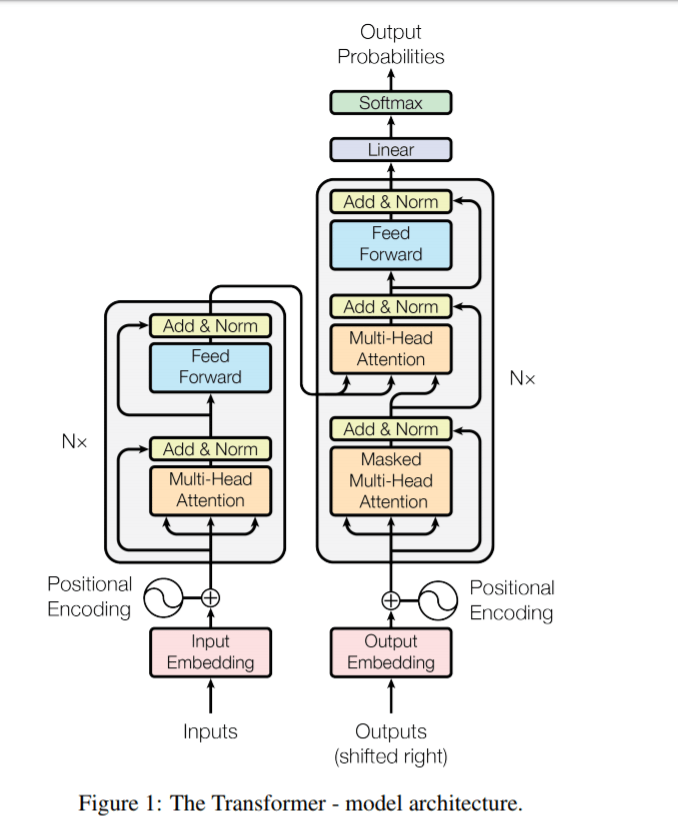

In [10]:
"""
taken from: https://github.com/karpathy/minGPT/
GPT model:
- the initial stem consists of a combination of token encoding and a positional encoding
- the meat of it is a uniform sequence of Transformer blocks
    - each Transformer is a sequential combination of a 1-hidden-layer MLP block and a self-attention block
    - all blocks feed into a central residual pathway similar to resnets
- the final decoder is a linear projection into a vanilla Softmax classifier
"""

import math
import torch
import torch.nn as nn
from torch.nn import functional as F


class GPTConfig:
    """ base GPT config, params common to all GPT versions """
    embd_pdrop = 0.1
    resid_pdrop = 0.1
    attn_pdrop = 0.1

    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        for k, v in kwargs.items():
            setattr(self, k, v)


class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        # output projection
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        mask = torch.tril(torch.ones(config.block_size,
                                     config.block_size))
        if hasattr(config, "n_unmasked"):
            mask[:config.n_unmasked, :config.n_unmasked] = 1
        self.register_buffer("mask", mask.view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head

    def forward(self, x, layer_past=None):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)

        present = torch.stack((k, v))
        if layer_past is not None:
            past_key, past_value = layer_past
            k = torch.cat((past_key, k), dim=-2)
            v = torch.cat((past_value, v), dim=-2)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        if layer_past is None:
            att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))

        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # re-assemble all head outputs side by side

        # output projection
        y = self.resid_drop(self.proj(y))
        return y, present  # TODO: check that this does not break anything


class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),  # nice
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )

    def forward(self, x, layer_past=None, return_present=False):
        # TODO: check that training still works
        if return_present:
            assert not self.training
        # layer past: tuple of length two with B, nh, T, hs
        attn, present = self.attn(self.ln1(x), layer_past=layer_past)

        x = x + attn
        x = x + self.mlp(self.ln2(x))
        if layer_past is not None or return_present:
            return x, present
        return x


class GPT(nn.Module):
    """  the full GPT language model, with a context size of block_size """

    def __init__(self, vocab_size, block_size, n_layer=12, n_head=8, n_embd=256,
                 embd_pdrop=0., resid_pdrop=0., attn_pdrop=0., n_unmasked=0):
        super().__init__()
        config = GPTConfig(vocab_size=vocab_size, block_size=block_size,
                           embd_pdrop=embd_pdrop, resid_pdrop=resid_pdrop, attn_pdrop=attn_pdrop,
                           n_layer=n_layer, n_head=n_head, n_embd=n_embd,
                           n_unmasked=n_unmasked)
        # input embedding stem
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))  # 512 x 1024
        self.drop = nn.Dropout(config.embd_pdrop)
        # transformer
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        # decoder head
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        self.block_size = config.block_size
        self.apply(self._init_weights)
        self.config = config

    def get_block_size(self):
        return self.block_size

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, idx, embeddings=None):
        token_embeddings = self.tok_emb(idx)  # each index maps to a (learnable) vector

        if embeddings is not None:  # prepend explicit embeddings
            token_embeddings = torch.cat((embeddings, token_embeddings), dim=1)

        t = token_embeddings.shape[1]
        assert t <= self.block_size, "Cannot forward, model block size is exhausted."
        position_embeddings = self.pos_emb[:, :t, :]  # each position maps to a (learnable) vector
        x = self.drop(token_embeddings + position_embeddings)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)

        return logits, None

### VQVAE transformer for image generation and learning which codebook indices work together

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VQGANTransformer(nn.Module):
    def __init__(self, args):
        super(VQGANTransformer, self).__init__()

        self.sos_token = args['sos-token']

        self.vqgan = self.load_vqgan(args)

        transformer_config = {
            "vocab_size": args['num-codebook-vectors'],
            "block_size": 256,
            "n_layer": 24,
            "n_head": 8,
            "n_embd": 1024
        }
        self.transformer = GPT(**transformer_config)

        self.pkeep = args['pkeep']
    
    # Just loading the trained VQ-VAE

    @staticmethod
    def load_vqgan(args):
        model = VQGAN(args)
        model.load_checkpoint(args['checkpoint-path'])
        model = model.eval()
        return model

    # Just getting the encoding of the image and getting the
    # codebook_mapping, codebook_indices, q_loss getting this 
    # Also with no grad as we have already trained the codebook
    @torch.no_grad()
    def encode_to_z(self, x):
        quant_z, indices, _ = self.vqgan.encode(x)
        indices = indices.view(quant_z.shape[0], -1)
        return quant_z, indices

    # Converting it back to image
    # Again without the grad as we have alerady trained the encoder
    # and also the decoder
    @torch.no_grad()
    def z_to_image(self, indices, p1=8, p2=8):
        ix_to_vectors = self.vqgan.codebook.embedding(indices).reshape(indices.shape[0], p1, p2, 256)
        ix_to_vectors = ix_to_vectors.permute(0, 3, 1, 2)
        image = self.vqgan.decode(ix_to_vectors)
        return image

    # Changed this as the repo doesnt train the transformer in the same 
    def forward(self, x):
        _, indices = self.encode_to_z(x)
        sos_tokens = torch.ones(x.shape[0], 1) * self.sos_token
        sos_tokens = sos_tokens.long().to("cuda")
        start_indices = indices[:, :indices.shape[1] // 2]
        random_indices = torch.randint_like(start_indices, self.transformer.config.vocab_size)
        new_indices = torch.cat((start_indices, random_indices), dim=1)
        new_indices = torch.cat((sos_tokens, new_indices), dim=1)        
        target = indices
        logits, _ = self.transformer(new_indices[:, :-1])

        return logits, target

    def top_k_logits(self, logits, k):
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        out[out < v[..., [-1]]] = -float("inf")
        return out

    @torch.no_grad()
    def sample(self, x, c, steps, temperature=1.0, top_k=100):
        self.transformer.eval()
        x = torch.cat((c, x), dim=1)
        for k in range(steps):
            logits, _ = self.transformer(x)
            logits = logits[:, -1, :] / temperature

            if top_k is not None:
                logits = self.top_k_logits(logits, top_k)

            probs = F.softmax(logits, dim=-1)

            ix = torch.multinomial(probs, num_samples=1)

            x = torch.cat((x, ix), dim=1)

        x = x[:, c.shape[1]:]
        self.transformer.train()
        return x

    @torch.no_grad()
    def log_images(self, x):
        log = dict()

        _, indices = self.encode_to_z(x)
        sos_tokens = torch.ones(x.shape[0], 1) * self.sos_token
        sos_tokens = sos_tokens.long().to("cuda")

        start_indices = indices[:, :indices.shape[1] // 2]
        sample_indices = self.sample(start_indices, sos_tokens, steps=indices.shape[1] - start_indices.shape[1])
        half_sample = self.z_to_image(sample_indices)

        start_indices = indices[:, :0]
        sample_indices = self.sample(start_indices, sos_tokens, steps=indices.shape[1])
        full_sample = self.z_to_image(sample_indices)

        x_rec = self.z_to_image(indices)

        log["input"] = x
        log["rec"] = x_rec
        log["half_sample"] = half_sample
        log["full_sample"] = full_sample

        return log, torch.concat((x, x_rec, half_sample, full_sample))

    @torch.no_grad()
    def interpolation(self, x):
        input_length_tokens = [56,48,40,32,24,16,8]
        generations_with_visible_tokens = []
        log = dict()

        _, indices = self.encode_to_z(x)
        sos_tokens = torch.ones(x.shape[0], 1) * self.sos_token
        sos_tokens = sos_tokens.long().to("cuda")
        start_indices = indices[:, :0]
        sample_indices = self.sample(start_indices, sos_tokens, steps=indices.shape[1])
        full_sample = self.z_to_image(sample_indices)

        reconstruction = self.z_to_image(indices)

        log["input"] = x
        log["rec"] = reconstruction

        # Interpolating from showing the number of tokens here [56,48,40,32,24,16,8]
        for i in range(len(input_length_tokens)):
            start_indices = indices[:, :input_length_tokens[i]]
            sample_indices = self.sample(start_indices, sos_tokens, steps=indices.shape[1] - start_indices.shape[1])
            hidden_tokens_generation = self.z_to_image(sample_indices)
            generations_with_visible_tokens.append(hidden_tokens_generation)
            log[f'sample{input_length_tokens[i]}'] =hidden_tokens_generation
            
        log["full_sample"] = full_sample

        out = []
        out.append(x)
        out.append(reconstruction)
        out.extend(generations_with_visible_tokens)
        out.append(full_sample)
        return log, torch.concat(out)

### Training the Transformer

In [ ]:
import os
import numpy as np
from tqdm import tqdm
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import utils as vutils

data_dir = './dataset/' 

train_loader = torch.utils.data.DataLoader(dataset, batch_size=4,
                                         shuffle=True, num_workers=2)

class TrainTransformer:
    def __init__(self, args):
        self.model = VQGANTransformer(args).to(device=args['device'])
                       
        if int(args['resume_training']) > 0:
            self.model.load_state_dict(torch.load(f"Model_dictionaries/transformer_{args['resume_training']}.pt"))

        self.optim = self.configure_optimizers()

        self.train(args)

    def configure_optimizers(self):
        decay, no_decay = set(), set()
        whitelist_weight_modules = (nn.Linear, )
        blacklist_weight_modules = (nn.LayerNorm, nn.Embedding)

        for mn, m in self.model.transformer.named_modules():
            for pn, p in m.named_parameters():
                fpn = f"{mn}.{pn}" if mn else pn

                if pn.endswith("bias"):
                    no_decay.add(fpn)

                elif pn.endswith("weight") and isinstance(m, whitelist_weight_modules):
                    decay.add(fpn)

                elif pn.endswith("weight") and isinstance(m, blacklist_weight_modules):
                    no_decay.add(fpn)

        no_decay.add("pos_emb")

        param_dict = {pn: p for pn, p in self.model.transformer.named_parameters()}

        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": 0.01},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]

        optimizer = torch.optim.AdamW(optim_groups, lr=4.5e-06, betas=(0.9, 0.95))
        return optimizer

    def train(self, args):
        train_dataset = train_loader
        for epoch in range(args['resume_training']+1, args['epochs']):
            with tqdm(range(len(train_dataset))) as pbar:
                for i, imgs in zip(pbar, train_dataset):
                    self.optim.zero_grad()
                    imgs, _ = imgs
                    imgs = imgs
                    imgs = imgs.to(device=args['device'])
                    logits, targets = self.model(imgs)
                    loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1))
                    loss.backward()
                    self.optim.step()
                    pbar.set_postfix(Transformer_Loss=np.round(loss.cpu().detach().numpy().item(), 4))
                    pbar.update(0)
            if epoch % 15 == 0:
                log, sampled_imgs = self.model.log_images(imgs[0][None])
                vutils.save_image(sampled_imgs, os.path.join("results", f"transformer_{epoch}.jpg"), nrow=4)
                plot_images(log)
                torch.save(self.model.state_dict(), os.path.join("Model_dictionaries", f"transformer_{epoch}.pt"))

arguments_transformer = dict()
arguments_transformer['latent-dim'] = 256
arguments_transformer['image-size'] = 128
arguments_transformer['num-codebook-vectors'] = 1024
arguments_transformer['beta'] = 0.25
arguments_transformer['image-channels'] = 3
arguments_transformer['device'] = 'cuda'
arguments_transformer['batch-size'] = 16
arguments_transformer['epochs'] = 16
arguments_transformer['learning-rate'] = 2.25e-05
arguments_transformer['beta1'] = 0.5
arguments_transformer['beta2'] = 0.9
arguments_transformer['disc-start'] = 10000
arguments_transformer['disc-factor'] = 1.
arguments_transformer['l2-loss-factor'] = 1.
arguments_transformer['perceptual-loss-factor'] = 1.
arguments_transformer['resume_training'] = 0
arguments_transformer['pkeep'] = 0.5
arguments_transformer['sos-token'] = 0
arguments_transformer['checkpoint-path'] = './Model_dictionaries/vqgan_parameters.pt'
train_transformer = TrainTransformer(arguments_transformer)

### Sampling Images 

#### This code cell samples the images and saves them in the directory

In [18]:
arguments_sampling = dict()
arguments_sampling['latent-dim'] = 256
arguments_sampling['image-size'] = 128
arguments_sampling['num-codebook-vectors'] = 1024
arguments_sampling['beta'] = 0.25
arguments_sampling['image-channels'] = 3
arguments_sampling['device'] = 'cuda'
arguments_sampling['batch-size'] = 16
arguments_sampling['epochs'] = 16
arguments_sampling['learning-rate'] = 2.25e-05
arguments_sampling['beta1'] = 0.5
arguments_sampling['beta2'] = 0.9
arguments_sampling['disc-start'] = 10000
arguments_sampling['disc-factor'] = 1.
arguments_sampling['l2-loss-factor'] = 1.
arguments_sampling['perceptual-loss-factor'] = 1.
arguments_sampling['pkeep'] = 0.5
arguments_sampling['sos-token'] = 0
arguments_sampling['checkpoint-path'] = './Model_dictionaries/vqgan_parameters.pt'
arguments_sampling['dataset_path'] = './dataset'
arguments_sampling['no_samples'] = 1


n = arguments_sampling['no_samples']
transformer = VQGANTransformer(arguments_sampling).to("cuda")
transformer.load_state_dict(torch.load(os.path.join("transformer_parameters", ".pt")))
print("Loaded state dict of Transformer")

for i in tqdm(range(n)):
    start_indices = torch.zeros((64, 0)).long().to("cuda")
    sos_tokens = torch.ones(start_indices.shape[0], 1) * 0
    sos_tokens = sos_tokens.long().to("cuda")
    sample_indices = transformer.sample(start_indices, sos_tokens, steps=64)
    sampled_imgs = transformer.z_to_image(sample_indices)
    vutils.save_image(sampled_imgs, os.path.join("./Images/Sampling", f"Sampled_imgs_{i}.jpg"), nrow=8)
    plt.show(sampled_imgs)

Loaded state dict of Transformer


100%|██████████| 1/1 [00:32<00:00, 32.63s/it]


#### This is to visualise the images in .ipynb notebook

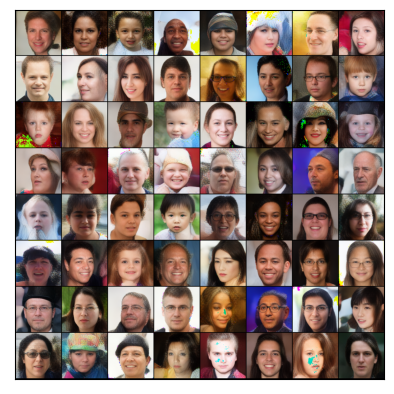

In [39]:
# from https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as Fan

plt.rcParams["savefig.bbox"] = 'tight'
grid = vutils.make_grid(sampled_imgs)
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = Fan.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
show(grid)

### Interpolation of Images
This code cell does both interpolation of images, : saving the interpolations and also displaying them in the notebook

Loaded data sucessfully
torch.Size([8, 3, 128, 128])
['input', 'rec', 'sample56', 'sample48', 'sample40', 'sample32', 'sample24', 'sample16', 'sample8', 'full_sample']
torch.Size([8, 3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


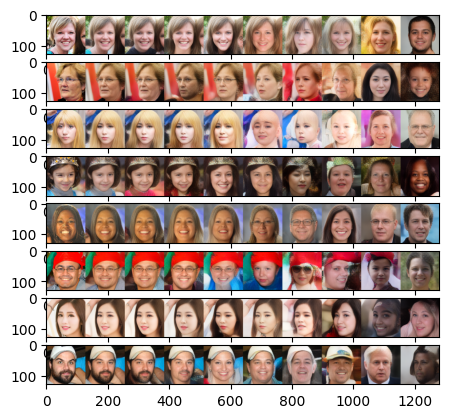

In [52]:
data_dir = './dataset/' 
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8,shuffle=True, num_workers=0)
train_iterator = iter(cycle(train_loader))

print('Loaded data sucessfully')

batch = train_iterator.__next__()[0]
img = batch.to(arguments_sampling['device'])
# print(img.shape)
log, sampled_imgs = transformer.interpolation(img)
# print(list(log.keys()))
# print(log['sample56'].shape)
vutils.save_image(sampled_imgs, os.path.join("./Images/Interpolation", f"interpolation_.jpg"))
plot_interpolationss(log)

### README
### VQVAE.ipynb
This has all the code with the training and the models 
### Model_dictionaries
This has the checkpoints or the dictionaries with the saved parameters for my model which can be loaded to sample images if needed
### Images 
This folder is where images are saved it will have subfolders which would be created
### To run the .ipynb place the 'dataset' folder with FFHQ in this main directory for all the cells to run normally
### To sample images with 8 \times 8 grid please run the third last cell after initialising the models
### To generate interpolations please run the last cell